In [2]:
import torch
import os
import sys
import os
import numpy as np
from torch import nn
import torchmetrics
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Compose 
from scipy.special import softmax
from tqdm import tqdm
sys.path.insert(0,'../../utils')
from models import Resnet_regime_3
from model_resnet import Resnet20_classic

In [2]:
model_1 = Resnet_regime_3.load_from_checkpoint("bnn_1.ckpt")
model_01 = Resnet_regime_3.load_from_checkpoint("bnn_01.ckpt")
model_001 = Resnet_regime_3.load_from_checkpoint("bnn_001.ckpt")
model_10 = Resnet_regime_3.load_from_checkpoint("bnn_10.ckpt")
model_100 = Resnet_regime_3.load_from_checkpoint("bnn_100.ckpt")
#model_500 = Resnet_regime_3.load_from_checkpoint("bnn_500.ckpt")
model_1000 = Resnet_regime_3.load_from_checkpoint("bnn_1000.ckpt")
model_0001 = Resnet_regime_3.load_from_checkpoint("bnn_0001.ckpt")

In [3]:
nn_1 = Resnet20_classic.load_from_checkpoint("nn_1.ckpt")
nn_01 = Resnet20_classic.load_from_checkpoint("nn_01.ckpt")
nn_001 = Resnet20_classic.load_from_checkpoint("nn_001.ckpt")
nn_10 = Resnet20_classic.load_from_checkpoint("nn_10.ckpt")
nn_100 = Resnet20_classic.load_from_checkpoint("nn_100.ckpt")
#nn_500 = Resnet20_classic.load_from_checkpoint("nn_500.ckpt")
nn_1000 = Resnet20_classic.load_from_checkpoint("nn_1000.ckpt")
nn_0001 = Resnet20_classic.load_from_checkpoint("nn_0001.ckpt")

In [4]:
batch_size = 10
num_works= 0
test_transform = Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
val_dataset = CIFAR10('../', download=True, transform=test_transform, train=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_works)

Files already downloaded and verified


In [5]:
def compute(model, dataset, device, nb_samples):
    acc, ece, nll, conf = 0, 0, 0, 0
    batch_size = 10
    results = torch.empty(len(dataset), batch_size, nb_samples, 10).to(device)
    labels = torch.empty(len(dataset), batch_size)
    for batch_idx, (x, y) in enumerate(tqdm(dataset)):
        x = x.to(device)
        y = y.to(device)
        labels[batch_idx, :] = y
        for idx in range(nb_samples):
            results[batch_idx, :, idx, :] = model(x).softmax(dim=1)
    return results.detach().cpu(), labels.detach().cpu()

In [6]:
models = [
        (0.001, model_0001, nn_0001),
        (0.01, model_001, nn_001),
        (0.1, model_01, nn_01),
        (1., model_1, nn_1),
        (10, model_10, nn_10),
        (100, model_100, nn_100),
        (500, model_1000, nn_1000)]

In [ ]:
eta_list, results_list, results_nn_list = [], [], []
for eta, model, model_nn in models:
    print(eta, model.model_params['w'])
    results, labels = compute(model, val_loader, torch.device('cpu'), 3)
    results_nn, labels_nn = compute(model_nn, val_loader, torch.device('cpu'), 1)
    eta_list.append(eta)
    results_list.append((results, labels))
    results_nn_list.append((results_nn, labels_nn))


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

0.001 541812


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [08:20<06:47,  1.19s/it]

In [172]:
ECE = torchmetrics.CalibrationError(n_bins=15, norm='l1')
accuracy = torchmetrics.Accuracy()
criterion = nn.CrossEntropyLoss(reduction='mean')

def get_acc(pred, true):
    accuracy.update(pred, true)
    acc = accuracy.compute()
    accuracy.reset()
    return acc.item()

def get_ece(pred, true):
    ECE.update(pred, true)
    ece = ECE.compute()
    ECE.reset()
    return ece.item()
    
def get_nll(pred, true):
    return criterion(pred, true).item()

def get_conf(pred, true):
    conf = torch.max(pred.softmax(dim=1), dim=1).values.mean().item()
    return conf

def export(results, labels):
    flattened_result = results.flatten(0, 1) # nb points samples, 10
    flattened_label = labels.flatten().long()
    nb_samples = flattened_result.size()[1]
    acc = [get_acc(flattened_result[:, idx, :], flattened_label) for idx in range(nb_samples)]
    ece = [get_ece(flattened_result[:, idx, :], flattened_label) for idx in range(nb_samples)]
    nll  =[get_nll(flattened_result[:, idx, :], flattened_label) for idx in range(nb_samples)]
    conf = [get_conf(flattened_result[:, idx, :], flattened_label) for idx in range(nb_samples)]
    avg_result = torch.mean(flattened_result, dim=1)
    print(get_acc(avg_result, flattened_label))
    return acc, ece, nll, conf

def export_all(results_list):
    acc_list, ece_list, nll_list, conf_list = [], [], [], []
    for (results, labels) in results_list:
        acc, ece, nll, conf = export(results, labels)
        acc_list.append((np.mean(acc), np.std(acc)))
        ece_list.append((np.mean(ece), np.std(ece)))
        nll_list.append((np.mean(nll), np.std(nll)))
        conf_list.append((np.mean(conf), np.std(conf)))
    return np.array(acc_list), np.array(ece_list), np.array(nll_list), np.array(conf_list)       
        
        

In [173]:
import pickle as pkl
results = pkl.load(open('results.pkl', 'rb'))
eta_list = results['eta_list']
results_list = results['results_list']
results_nn_list = results['results_nn_list']

In [174]:
len(results_list[0][0])

50

In [175]:
batch_size = 200

In [176]:
acc_bnn, ece_bnn, nll_bnn, conf_bnn = export_all(results_list)
acc_nn, ece_nn, nll_nn, conf_nn = export_all(results_nn_list)

0.8328999876976013
0.8131999969482422
0.8450000286102295
0.8475000262260437
0.7960000038146973
0.4099000096321106
0.10249999910593033
0.8597999811172485
0.8671000003814697
0.8593999743461609
0.8623999953269958
0.8567000031471252
0.8598999977111816
0.8608999848365784


In [148]:
def plot(x, y, y_nn, title):
    plt.plot(x, y[:, 0], '-o', label='BNN')
    ci = 1.96 * y[:, 1] / len(y)
    plt.fill_between(x, (y[:, 0]-ci), (y[:, 0]+ci), color='r', alpha=0.5)
    plt.plot(x, y_nn[:, 0], '-o', label='NN')
    plt.xscale('log')
    plt.legend()
    plt.title(title)
    plt.show()

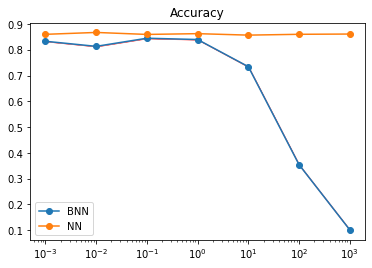

In [149]:
plot(eta_list, acc_bnn, acc_nn, 'Accuracy')

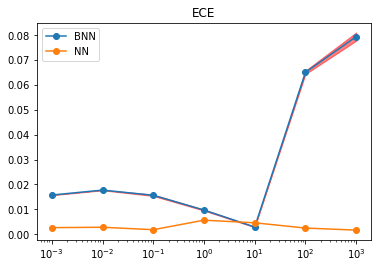

In [151]:
plot(eta_list, ece_bnn, ece_nn, 'ECE')